# Polynomial fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's consider the example of fitting a polynomial to some measurements of $y_i(x_i)$ (ie. $y$ measured at a set of points $x_i$). An obvious way to solve the normal equations

$$\mathbf{A^T} \mathbf{d} = \mathbf{A^T}\mathbf{A}\mathbf{a}$$ 

is to calculate the inverse of $\mathbf{A^T}\mathbf{A}$ and write

$$\mathbf{a} = (\mathbf{A^T}\mathbf{A})^{-1} \mathbf{A^T} \mathbf{d}.$$

For simplicity, let's take a constant error $\sigma_i$ for each point, so the $\sigma_i$'s drop out of the equations and we'll just ignore them. 

Polynomial coeffs =  [-0.08183424 -0.43254686 -0.18893     0.60685865  0.96228237 -0.49706461
 -0.91780677 -0.17740619  0.29815188 -0.84552489 -0.08772226]
Fitted coeffs =  [-0.19930902 -0.43254686  6.56500165  0.60685868 -1.85188364 -0.49706461
 -0.48267869 -0.17740619  0.2523617  -0.84552489 -0.09221752]
frac error =  [ 1.43552093e+00  4.29743339e-09 -3.57483279e+01  4.46997345e-08
 -2.92447009e+00  4.75474501e-09 -4.74095528e-01  1.42266096e-08
 -1.53580061e-01 -4.64360780e-10  5.12442337e-02]


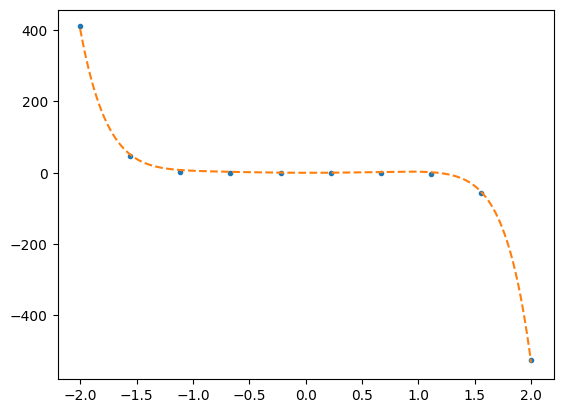

In [2]:
# first generate some data from a random polynomial

k = 10   # order of polynomial
n = 10   # number of data points

x = np.linspace(-2,2,n)
a0 = -1.0 + 2*np.random.rand(k+1)
print("Polynomial coeffs = ", a0)
poly = np.polynomial.Polynomial(a0)
y = poly(x) + np.random.normal(scale=0.0, size=n)
plt.plot(x,y,'.')

# Compute the design matrix
# A_{ij} = f_j(x_i)
A = np.zeros((n, k+1))
for kk in range(k+1):
    A[:, kk] = x**kk

# Now do the linear algebra part 
rhs = np.transpose(A)@y
lhs = np.transpose(A)@A
a = np.linalg.inv(lhs)@rhs

print("Fitted coeffs = ", a)
print("frac error = ", (a-a0)/a0)

xx = np.linspace(-2,2,1000)
poly = np.polynomial.Polynomial(a)
yy = poly(xx)
plt.plot(xx,yy,'--')

plt.show()


If you run this with no noise (`scale=0` on line 10), you should see that for low polynomial order the coefficients are fit to machine precision, but the errors become large pretty quickly as you increase the polynomial order. Something is going horribly wrong with the matrix inversion as the polynomial order increases!

## Using SVD

Singular value decomposition (SVD) is extremely useful in these situations where you are dealing with a close-to-singular matrix. The ratio of the largest to smallest singular values is known as the **condition number** of the matrix, and measures how close to singular it is.

In [3]:
U, Sdiag, VT = np.linalg.svd(A,0)

print("Range of singular values = %g" % (max(abs(Sdiag))/min(abs(Sdiag))))

print("np.linalg.cond gives %g" % (np.linalg.cond(A)))

Range of singular values = 37411
np.linalg.cond gives 37411


Let's use SVD to rewrite the normal equations:

$$\mathbf{A^T} \mathbf{d} = \mathbf{A^T}\mathbf{A}\mathbf{a}$$ 

$$ \mathbf{VSU^T} \mathbf{d} = \mathbf{VSU^T}\mathbf{USV^T} \mathbf{a}$$ 

$$ \mathbf{VSU^T} \mathbf{d} = \mathbf{VS^2V^T} \mathbf{a}$$ 

$$ \mathbf{V^TVS}\mathbf{U^T} \mathbf{d} = \mathbf{V^T}\mathbf{VS^2V^T} \mathbf{a}$$ 

$$ \mathbf{SU^T} \mathbf{d} = \mathbf{S^2V^T} \mathbf{a}$$ 

$$ \mathbf{U^T} \mathbf{d} = \mathbf{SV^T} \mathbf{a}$$ 

$$\Rightarrow \mathbf{VS^{-1}}\mathbf{U^T} \mathbf{d} =  \mathbf{a}$$ 

The matrix $\mathbf{VS^{-1}}\mathbf{U^T}$ is called the **pseudo-inverse**. We can use it to map from the data vector $\mathbf{d}$ to the model parameters $\mathbf{a}$.


Fitted coeffs =  [-0.09322416 -0.43254686  0.08412339  0.60685865  0.05847538 -0.49706461
  0.01186025 -0.17740619 -0.05571574 -0.84552489 -0.04429305]
frac error =  [ 1.39182716e-01 -1.05235175e-14 -1.44526222e+00  4.20775569e-15
 -9.39232614e-01  2.98180099e-14 -1.01292238e+00 -7.32195955e-14
 -1.18687032e+00  3.67656176e-15 -4.95076272e-01]


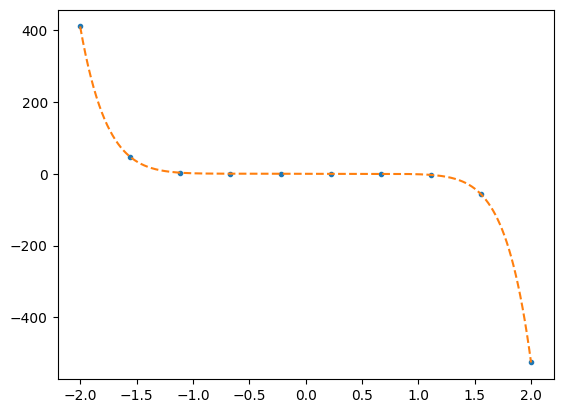

In [4]:
aSVD = VT.T @ np.diag(1/Sdiag) @ U.T @ y

print("Fitted coeffs = ", aSVD)
print("frac error = ", (aSVD-a0)/a0)

plt.plot(x,y,'.')

xx = np.linspace(-2,2,1000)
poly = np.polynomial.Polynomial(aSVD)
yy = poly(xx)
plt.plot(xx,yy,'--')

plt.show()

## Orthogonal polynomials

SVD does a lot better than straight inversion of the normal equations, but still fails for large enough polynomial order. One way that we can do better is to choose a set of basis functions that are orthogonal in the domain that we are interested in. For example, the Legendre polynomials are orthogonal on the domain $x=(-1,1)$ (which you can rescale to by rescaling your $x$ variable). 

**Exercise**:  Try changing the basis functions to Legendre polynomials and see how that improves the fit.

You can use [`numpy.polynomial.legendre.legvander`](https://numpy.org/devdocs/reference/generated/numpy.polynomial.legendre.legvander.html) to generate the design matrix $\mathbf{A}$ for you.